In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
# загрузим данные
df = pd.read_csv('/home/jupyter-m.gikalo-16/hw_aa.csv', sep = ';')
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [3]:
# посмотрим на типы данных
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [4]:
# посмотрим, нет ли пропусков в данных
df.isna().sum()

Unnamed: 0           0
uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [5]:
# зададим тестовые группы
var_zero = df.query('experimentVariant == 0').purchase
var_one  = df.query('experimentVariant == 1').purchase


FPR: 0.947


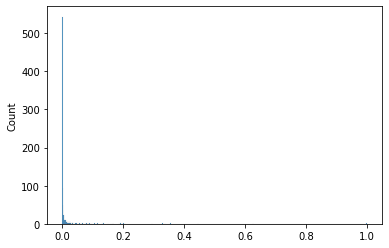

In [7]:
# возьмём код из лекции и проведём А/А тест
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = var_zero.sample(n_s, replace = False).values
    s2 = var_one.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

sns.histplot(res)

# Выводим количество ложноположительных случаев
print('FPR:', sum(np.array(res) <0.05) / simulations)

In [ ]:
# полученный FPR превышает альфа = 0.05, распределение неравномерное, следовательно в А/А тесте есть проблема
# предположим, она связана с наличием значительного отличия конверсии между версиями МП

In [16]:
# посмотрим, какие версии МП есть в датафрейме
df.version.unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

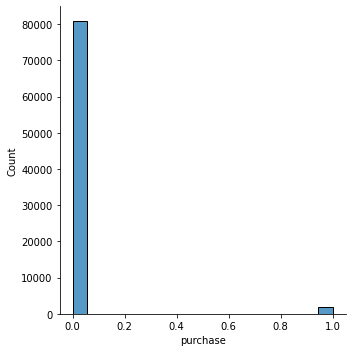

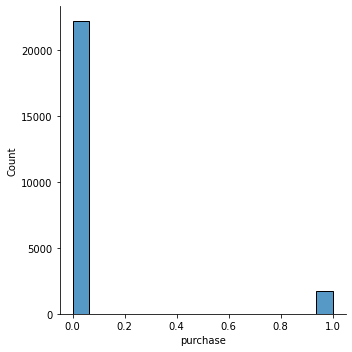

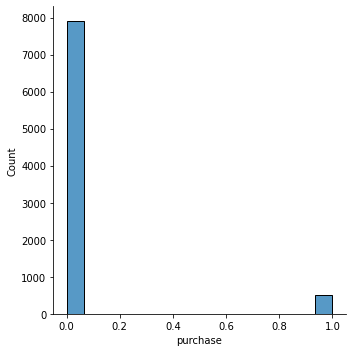

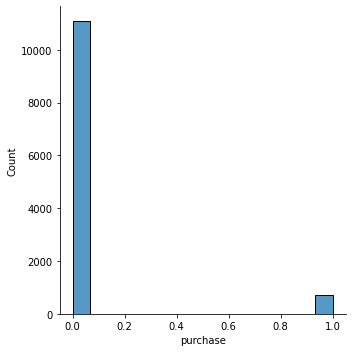

In [11]:
# построим распределение покупок для каждой из версий МП
sns.displot(df[df.version == 'v2.8.0'].purchase)
sns.displot(df[df.version == 'v2.9.0'].purchase)
sns.displot(df[df.version == 'v3.7.4.0'].purchase)
sns.displot(df[df.version == 'v3.8.0.0'].purchase)

In [12]:
# по графику видим, что в версии 2.8.0 конверсия гораздо меньше, чем в других версиях
# попробуем провести новый А/А тест, исключив версию 2.8.0

In [13]:
# сформируем новые тестовые группы
var_zero_adj = df.query('version != "v2.8.0" & experimentVariant == 0').purchase
var_one_adj  = df.query('version != "v2.8.0" & experimentVariant == 1').purchase


FPR: 0.039


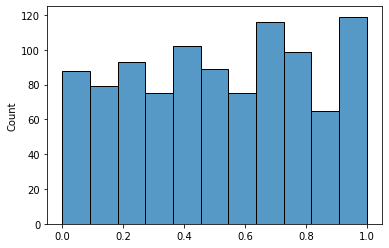

In [16]:
# проведём новый А/А тест
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = var_zero_adj.sample(n_s, replace = False).values
    s2 = var_one_adj.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

sns.histplot(res)

# Проверяем, что количество ложноположительных случаев не превышает альфа
print('FPR:', sum(np.array(res) <0.05) / simulations)

In [ ]:
# получаем FPR меньше 0.05, распределение близкое к равномерному
# теперь А/А тест работает

In [ ]:
# Вывод: причиной неисправности А/А теста была низкая конверсия в версии МП 2.8.0.